In [1]:
# standards
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 3rd party packages
import qiskit as qk
import networkx as nx
import tenpy as tp

## custom things
from networks.networks import IsoMPS
from networks.isonetwork import QKParamCircuit
import circuits.basic_circuits as circuits



## HoloPy demo: XXZ-chain
$$H=\sum_{i=1}^{L-1} \sigma^x_{i}\sigma^x_{i+1}+\sigma^y_{i}\sigma^y_{i+1} + \Delta \sigma^z_i\sigma^z_{i+1}$$

In [2]:
## Define model parameters ## 
Delta = 1.5 # Ising anisotropy 
nb = 2 # number of bond-qubits 

# ansatz parameters
L = 1 # number of unit cells
l_uc = 1 # number of sites in unit cell

In [3]:
## Setup IsoMPS ##
# initialize registers
preg = qk.QuantumRegister(1,'p') # physical qubits
breg = qk.QuantumRegister(nb,'b') # bond qubits
creg = qk.ClassicalRegister(L*l_uc+nb,'m') # classical register to hold measurement outcomes

## Initialize parameterized circuits
# bond-prep circuit (sets left-boundary vector of MPS)
bond_prep_circ = QKParamCircuit(qk.QuantumCircuit(breg),[])
pcircs = [bond_prep_circ]

# circuits that generate tensors
param_names= [] # list of circuit parameters
for j in range(l_uc):
    circ_tmp,params_tmp = circuits.star_circ(preg,
                                             breg,
                                             label='[c{}]'.format(j),
                                             circ_type='xxz') 
    pcircs+=[circ_tmp]
    param_names+=params_tmp

# setup circuit-generated isoMPS
psi = IsoMPS(preg,breg,pcircs,L=L)

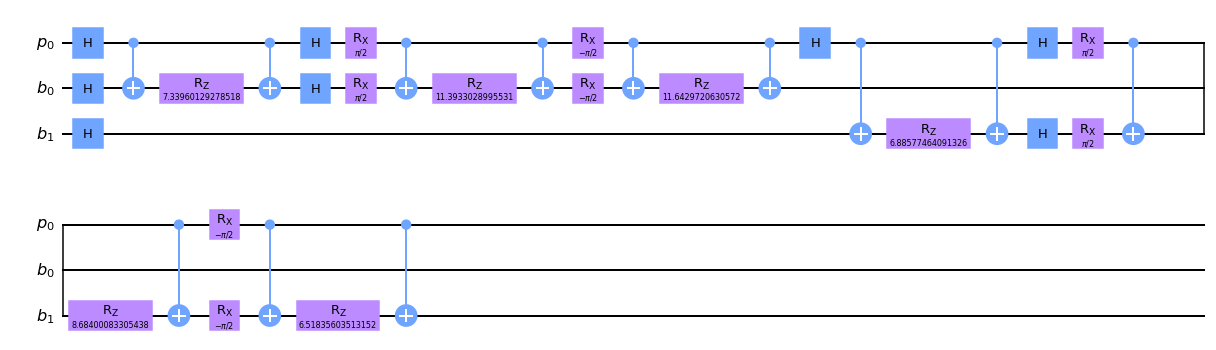

In [4]:
## Example (resolve parameters => random values and print circuit)
# pick some random parameter values
param_vals = [4*np.pi*np.random.rand() for j in range(len(param_names))]
param_dict = dict(zip(param_names,param_vals))
psi.construct_circuit(param_dict,include_measurements=False)
psi.circ.draw('mpl')

## 1. Compute energy by exporting to tenpy

In [5]:
## Setup XXZ model in Tenpy ##
from tenpy.models.xxz_chain import XXZChain
h_param_dict = {'L':10,'Jz':Delta,'hz':0}
model = XXZChain(h_param_dict)
H_mpo = model.calc_H_MPO()

# function to calculate energy using MPO/MPS contraction in tenpy
def energy_tp(param_vals,*args):
    """
    inputs:
        - param_vals = dict {parameter:value}
        - *args, 
            args[0] should be psi: state as IsoMPS
            args[1] should be H_mpo: Hamiltonian as MPO
        (input made this way to be compatible w/ scipy.optimize)
    outputs:
        - float, <psi|H|psi> computed w/ tenpy
    """
    # parse inputs
    psi=args[0] # state as isoMPS    
    H_mpo = args[1] # Hamiltonian as tenpy MPO
    param_dict = dict(zip(param_names,param_vals))
    
    # convert state from holoPy isoMPS to tenpy MPS
    psi_tp = psi.to_tenpy(param_dict,L=np.inf)
    
    # compute energy
    E = (H_tp.expectation_value(psi_tp)).real
    return E

energy_tp(param_vals,psi,H_mpo)

Reading 'L'=10 for config XXZChain
Reading 'Jz'=1.5 for config XXZChain
Reading 'hz'=0 for config XXZChain
1 [<networks.isonetwork.IsoTensor object at 0x142e44b20>, <networks.isonetwork.IsoTensor object at 0x142e44b80>] 1


ValueError: Length of Bflat does not match number of sites.

In [ ]:
for j in range(l_uc+1):
    site = psi.sites[0][j]
    site_param_names = site.param_names
    site_param_vals = [param_dict[k] for k in site_param_names]
    site_param_dict = dict(zip(site_param_names,site_param_vals))
    print(site,site_param_dict)

In [ ]:
psi.l_uc